In [1]:
import nltk
import re
import string
import random
nltk.download('punkt')
nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
import pandas as pd
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import matplotlib as plt
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, classification_report, f1_score
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import os
from google.colab import drive
dataDir = '/content/drive/My Drive//Datasets/'
drive.mount('/content/drive')
TweetsDetails = os.path.join(dataDir, 'Tweets.csv')
tweet_data  = pd.read_csv(TweetsDetails)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['neutral' 'positive' 'negative']


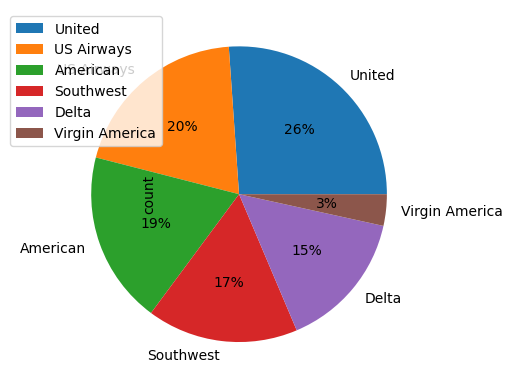

In [3]:
tweet_data['airline_sentiment'][0] #output label >> neutral , negative , positive
tweet_data.airline.value_counts().plot(kind='pie', autopct='%1.0f%%')
import seaborn as sns
#print list of unique values of airline_sentiment
print(tweet_data['airline_sentiment'].unique())
#shows the number of tweets in each sentiment category
ax = sns.countplot(x="airline_sentiment", data=tweet_data)


In [4]:
# Split text of Sentiments
positive = tweet_data[tweet_data['airline_sentiment'] == 'positive'].text #return positive tweet
neutral  = tweet_data[tweet_data['airline_sentiment'] == 'neutral'].text #return neutral tweet
negative  = tweet_data[tweet_data['airline_sentiment'] == 'negative'].text #return negative tweet

print(positive.head())
print("--------------------------------------------------")
print(neutral.head())
print("--------------------------------------------------")
print(negative.head())


1     @VirginAmerica plus you've added commercials t...
6     @VirginAmerica yes, nearly every time I fly VX...
8       @virginamerica Well, I didn't…but NOW I DO! :-D
9     @VirginAmerica it was amazing, and arrived an ...
11    @VirginAmerica I &lt;3 pretty graphics. so muc...
Name: text, dtype: object
--------------------------------------------------
0                   @VirginAmerica What @dhepburn said.
2     @VirginAmerica I didn't today... Must mean I n...
7     @VirginAmerica Really missed a prime opportuni...
10    @VirginAmerica did you know that suicide is th...
23    @VirginAmerica will you be making BOS&gt;LAS n...
Name: text, dtype: object
--------------------------------------------------
3     @VirginAmerica it's really aggressive to blast...
4     @VirginAmerica and it's a really big bad thing...
5     @VirginAmerica seriously would pay $30 a fligh...
15        @VirginAmerica SFO-PDX schedule is still MIA.
17    @VirginAmerica  I flew from NYC to SFO last we...
Name: 

In [5]:
# convert Sentiments to 0,1,2
sentiment = {'negative': 0, 'neutral':1,'positive':2} #dictionary to get each label(key) a numerical value
tweet_data['airline_sentiment']= tweet_data['airline_sentiment'].map(sentiment) #maps the text sentiment labels to numerical values in data
tweet_data['airline_sentiment']

0        1
1        2
2        1
3        0
4        0
        ..
14635    2
14636    0
14637    1
14638    0
14639    1
Name: airline_sentiment, Length: 14640, dtype: int64

In [6]:
# combaine negative reason with  tweet (if exsist)
tweet_data['final_text'] = tweet_data['negativereason'].fillna('') + ' ' + tweet_data['text']
# fillna replace any missing value to "" then combaine negative reason with  twee
tweet_data['final_text'][4]

"Can't Tell @VirginAmerica and it's a really big bad thing about it"

In [7]:
# Remove @username
def remove_username(text):
    return re.sub('@[^\s]+','',text)

# Remove url
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)


# Remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Decontraction text from skretch
def decontraction(text):
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text

# Seperate alphanumeric
def seperate_alphanumeric(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)
#
def cont_rep_char(text):
    tchr = text.group(0)

    if len(tchr) > 1:
        return tchr[0:2]

def unique_char(rep, text):
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

def char(text):
    substitute = re.sub(r'[^a-zA-Z]',' ',text)
    return substitute

# Remove stop words
def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in (stopwords.words('english'))])
    return text

# Remove punct
def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

In [8]:

# Apply functions on tweets
tweet_data['final_text'] = tweet_data['final_text'].apply(lambda x : remove_username(x))
tweet_data['final_text'] = tweet_data['final_text'].apply(lambda x : remove_url(x))
tweet_data['final_text'] = tweet_data['final_text'].apply(lambda x : remove_emoji(x))
tweet_data['final_text'] = tweet_data['final_text'].apply(lambda x : decontraction(x))
tweet_data['final_text'] = tweet_data['final_text'].apply(lambda x : seperate_alphanumeric(x))
tweet_data['final_text'] = tweet_data['final_text'].apply(lambda x : unique_char(cont_rep_char,x))
tweet_data['final_text'] = tweet_data['final_text'].apply(lambda x : char(x))
tweet_data['final_text'] = tweet_data['final_text'].apply(lambda x : x.lower())
tweet_data['final_text'] = tweet_data['final_text'].apply(lambda x : remove_stopwords(x))

#Transformer

In [9]:
Transform_data = tweet_data[['final_text', 'airline_sentiment']].copy()
# Train_set = 80%, Test_set = 20%
num_train_samples = int(0.80 * len(Transform_data))  # 80% for training
num_test_samples = len(Transform_data) - num_train_samples  # Remaining 20% for testing

train_data_transform = Transform_data[:num_train_samples]
test_data_transform = Transform_data[num_train_samples:]

print("Total data: ", len(Transform_data))
print("Training data_transform: ", len(train_data_transform))
print("Test data_transform: ", len(test_data_transform))

Total data:  14640
Training data_transform:  11712
Test data_transform:  2928


In [10]:
import tensorflow as tf
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize reviews to build the vocabulary
tokenized_data = train_data_transform['final_text'].apply(lambda x: x.split())
all_tokens = [token for sublist in tokenized_data for token in sublist]

# Create a Counter of tokens and sort by frequency
count_token = Counter(all_tokens)
sorted_count_token = sorted(count_token.items(), key=lambda item: item[1], reverse=True)

# Create vocabulary mapping words to indices with special tokens
vocab = {"<unk>": 0, "<pad>": 1, "<bos>": 2, "<eos>": 3}  # Special tokens <bos> for beginning of sequence, and <eos> for end of sequence
index = len(vocab)

#to complete pad with 1
for token, freq in sorted_count_token:
    if token not in vocab:
        vocab[token] = index
        index += 1

# Map words to indices and pad sequences
def preprocess_and_pad(text):
    tokens = text.split()
    indexed_tokens = [vocab.get(token, vocab['<unk>']) for token in tokens]
    return indexed_tokens

# Apply padding to sequences
max_seq_length = 100  # Set your desired sequence length
train_data_transform['padded_final_text'] = train_data_transform['final_text'].apply(preprocess_and_pad)
test_data_transform['padded_final_text'] = test_data_transform['final_text'].apply(preprocess_and_pad)

# Pad sequences to a fixed length /Padding is done after the sequences, and any sequences longer than the maximum length are truncated from the end.
train_sequences = pad_sequences(train_data_transform['padded_final_text'], maxlen=max_seq_length, padding='post', truncating='post', value=vocab['<pad>'])
test_sequences = pad_sequences(test_data_transform['padded_final_text'], maxlen=max_seq_length, padding='post', truncating='post', value=vocab['<pad>'])

# Convert the padded sequences to TensorFlow tensors to be used in TensorFlow operations
padded_train_sequences = tf.constant(train_sequences)
padded_test_sequences = tf.constant(test_sequences)

# Example of the prepared input data
print("Padded Train Sequences Shape:", padded_train_sequences.shape)
print("Padded Test Sequences Shape:", padded_test_sequences.shape)

Padded Train Sequences Shape: (11712, 100)
Padded Test Sequences Shape: (2928, 100)


In [11]:
#!pip uninstall keras
#!pip uninstall tensorflow

!pip install tensorflow
!pip install keras

import keras

from keras import ops
from keras import layers

Found existing installation: keras 3.3.3
Uninstalling keras-3.3.3:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/keras-3.3.3.dist-info/*
    /usr/local/lib/python3.10/dist-packages/keras/*
Proceed (Y/n)? n
Found existing installation: tensorflow 2.16.1
Uninstalling tensorflow-2.16.1:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.16.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? n


In [12]:
#a single block of a transformer
class Encoder_Transformer(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1): #rate: Dropout rate defaults to 0.1.
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)#1e-6, is a small constant added to the variance to avoid division by zero
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
# add layer
    def call(self, inputs):
        attn_output = self.att(inputs, inputs) #Q ,K OUT> attention weight
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output) #Adds the input inputs to the attention output (attn_output) and normalizes the result using layer normalization.
        ffn_output = self.ffn(out1) #Passes the output of the first layer normalization (out1) through the feedforward neural network
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output) # apply add and norm again

In [13]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()

         #input_dim: Specifies the size of the vocabulary, representing the number of unique tokens.
        #output_dim: Specifies the dimensionality of the embedding vectors
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim) #converts token indices to embedding vectors.
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim) #positional embeddings based on the position indices in the input sequence.

    def call(self, x): #x: Input tensor representing the token indices of the input sequence.
        maxlen = ops.shape(x)[-1] #ensures that positional embeddings are generated for the entire sequence length. /-1 selects the last element of the shape tensor, which corresponds to the length of the last dimension of x
        positions = ops.arange(start=0, stop=maxlen, step=1)#contains integers from 0 to maxlen - 1, representing the positions of tokens in the sequence.
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [14]:
vocab_size = len(vocab)  # Only consider the top 20k words
maxlen = max_seq_length  # Only consider the first 200 words of each movie review
# Train-validation split: 90% train, 10% validation
num_train_samples = int(0.90 * len(padded_train_sequences))
num_val_samples = len(padded_train_sequences) - num_train_samples

train_X = padded_train_sequences[:num_train_samples]
val_X = padded_train_sequences[num_train_samples:]

train_y = train_data_transform['airline_sentiment'][:num_train_samples]
val_y = train_data_transform['airline_sentiment'][num_train_samples:]

print("Total data: ", len(padded_train_sequences))
print("Training data: ", len(train_X))
print("Validation data: ", len(val_X))

Total data:  11712
Training data:  10540
Validation data:  1172


In [15]:
# import pandas as pd
# import tensorflow as tf
from sklearn.model_selection import train_test_split


# # # Prepare input and labels for the model
# X = padded_train_sequences
# y = train_data_transform['airline_sentiment'].values

# # Splitting the dataset into train and validation sets
# train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.1, random_state=42)

# Create TensorFlow datasets
train_data = tf.data.Dataset.from_tensor_slices((train_X, train_y))
val_data = tf.data.Dataset.from_tensor_slices((val_X, val_y))
test_data = tf.data.Dataset.from_tensor_slices((padded_test_sequences, test_data_transform['airline_sentiment'].values))

# Set up DataLoader
#phases to feed batches of data to the model for training, validation, and evaluation, respectively
batch_size = 32
train_loader = train_data.batch(batch_size).shuffle(buffer_size=len(train_X))
val_loader = val_data.batch(batch_size)
test_loader = test_data.batch(batch_size)

In [16]:
embed_dim = 32  # Embedding size for each token
num_heads = 5  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
#Each block performs self-attention and feedforward processing. The output of each block is passed as input to the next block.
transformer_block = Encoder_Transformer(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = transformer_block(x)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x) #reduces the spatial dimensions of the input and produces a fixed-length output vector.
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x) #Applies a fully connected layer with 20 units and ReLU activation function to the output tensor x
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [17]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_and_position_embed… │ (None, 100, 32)        │        322,784 │ input_layer[0][0]      │
│ (TokenAndPositionEmbeddi… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder__transformer      │ (None, 100, 32)        │         23,232 │ token_and_position_em… │
│ (Encoder_Transformer)     │                        │                │ encoder__transformer[… │
│                           │                        │                │ encoder__transformer[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 32)             │              0 │ encoder__transformer[… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32)             │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 20)             │            660 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 20)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 3)              │             63 │ dropout_4[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 346,739 (1.32 MB)

 Trainable params: 346,739 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint


#callbacks

EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('/model.keras',monitor='val_loss',verbose=1,save_best_only=True)#saves the model's weights to a file (/model.keras)
callback=[EarlyStop , Reduce_LR,model_check]

In [19]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    train_loader, batch_size=32, epochs=100, validation_data=(val_loader),callbacks=callback)

Epoch 1/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.5713 - loss: 0.9743
Epoch 1: val_loss improved from inf to 0.23842, saving model to /model.keras
330/330 ━━━━━━━━━━━━━━━━━━━━ 118s 329ms/step - accuracy: 0.5715 - loss: 0.9738 - val_accuracy: 0.8720 - val_loss: 0.2384 - learning_rate: 0.0010
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.8143 - loss: 0.3491
Epoch 2: val_loss improved from 0.23842 to 0.11954, saving model to /model.keras
330/330 ━━━━━━━━━━━━━━━━━━━━ 113s 243ms/step - accuracy: 0.8144 - loss: 0.3490 - val_accuracy: 0.9565 - val_loss: 0.1195 - learning_rate: 0.0010
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9180 - loss: 0.2214
Epoch 3: val_loss improved from 0.11954 to 0.11030, saving model to /model.keras
330/330 ━━━━━━━━━━━━━━━━━━━━ 80s 236ms/step - accuracy: 0.9180 - loss: 0.2213 - val_accuracy: 0.9556 - val_loss: 0.1103 - learning_rate: 0.0010
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - acc

In [20]:
loss , accuracy = model.evaluate(test_loader)

92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 0.9345 - loss: 0.1814


In [21]:
print('loss of test : ',loss)
print('accuracy of test  : ',accuracy)

loss of test :  0.14835207164287567
accuracy of test  :  0.9470628499984741


In [22]:
#plotting training values
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

<Figure size 640x480 with 0 Axes>

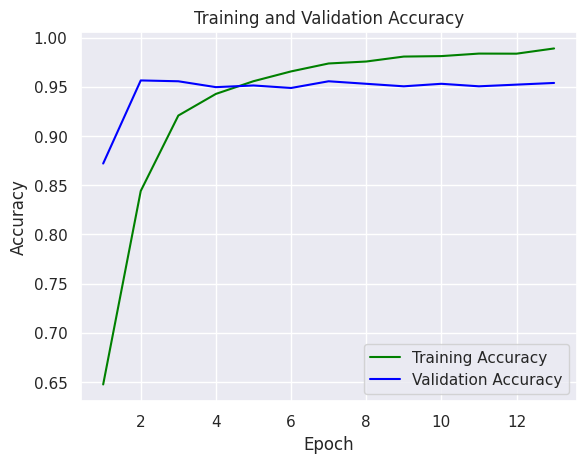

<Figure size 640x480 with 0 Axes>

In [23]:
#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.figure()

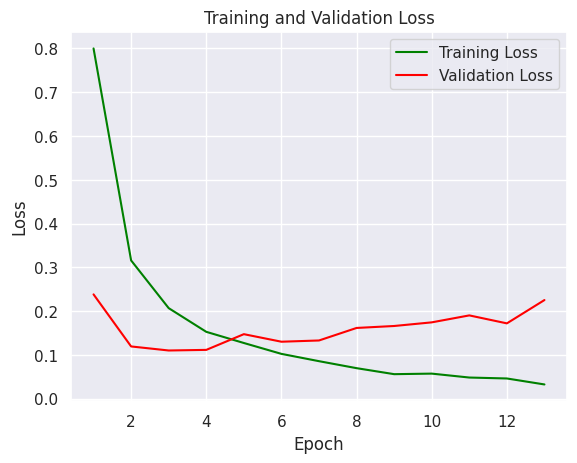

In [24]:
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

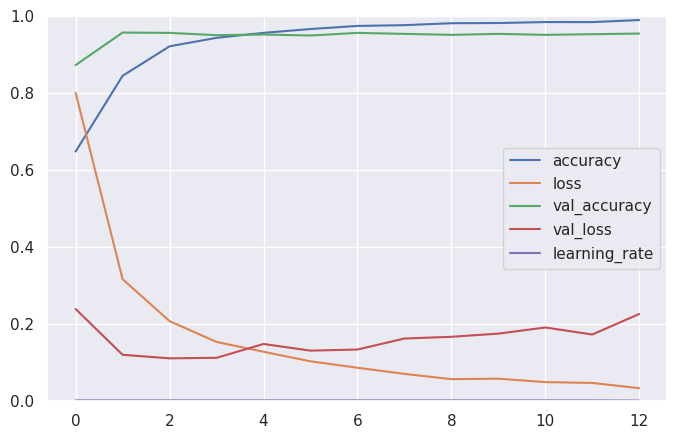

In [25]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [26]:
predictions = model.predict(test_loader)

92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step


In [27]:
from sklearn.metrics import classification_report
print(classification_report(test_data_transform['airline_sentiment'], predictions.argmax(axis=-1)))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2087
           1       0.87      0.81      0.84       482
           2       0.78      0.84      0.81       359

    accuracy                           0.95      2928
   macro avg       0.88      0.88      0.88      2928
weighted avg       0.95      0.95      0.95      2928



<Axes: >

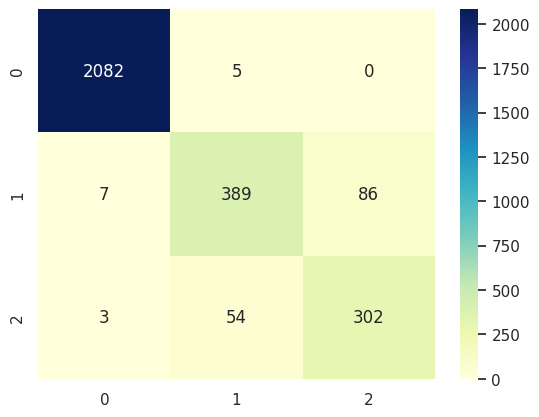

In [28]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_data_transform['airline_sentiment'], predictions.argmax(axis=-1))

sns.heatmap(cm,  annot=True, fmt="d" ,cmap="YlGnBu")